In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import (RandomForestClassifier,
                              GradientBoostingClassifier,
                              AdaBoostClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, log_loss, mean_squared_error

In [2]:
import utils as ut 
%load_ext autoreload
%autoreload 2

In [3]:
# params 
test_ratio = 0.2
calibration_ratio = 0.2 

In [4]:
X, y = ut.load_data('credit')

Number of total samples:    30000
Number of positive samples: 6636


In [43]:
clfs = [
    (GradientBoostingClassifier(n_estimators=50), 'Gradient Boosting'),
    (LogisticRegression(), 'Logistic Regression'),
    (AdaBoostClassifier(DecisionTreeClassifier(max_depth=4), n_estimators=5), 'AdaBoost'),
]

reliab_plot = {}
results = []
gamma = 0.5

B = 50
num_iter = 10
for clf, clf_name in clfs:
  for gamma in np.linspace(0.1, 0.9, 10):
    for run in range(5):
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
      X_train, X_cal, y_train, y_cal = train_test_split(X_train, y_train, test_size=gamma)
      n_tot = len(y_train) + len(y_cal)
      # original clf
      clf = Pipeline([('scaler', StandardScaler()), (clf_name, clf)])
      clf.fit(X_train, y_train)
      y_pred = clf.predict_proba(X_test)[:, 1]
      mean_proba, mean_true, K1, K2 = ut.expected_calibration_error(np.asarray(y_test),
                                                                y_pred, num_bins=B)
      mse = mean_squared_error(y_pred, y_test)
      reliab_plot[clf_name] = (mean_proba, mean_true)

      auc = roc_auc_score(y_test, y_pred)
      print('Uncalibrated')
      print('AUC on test set:     {:6.3f}'.format(auc))
      print(f'K1 error {K1} K2 error {K2}')

      # bin calibration
      intervals, values = ut.bin_calibrate(clf.predict_proba(X_cal)[:, 1], y_cal, B)
      y_pred = ut.calibrated_mapping(y_pred, intervals, values)
      mean_proba, mean_true, K1_c, K2_c = ut.expected_calibration_error(np.asarray(y_test),
                                                                    y_pred, num_bins=B)
      auc_c = roc_auc_score(y_test, y_pred)
      mse_c = mean_squared_error(y_pred, y_test)
      print('Calibrated')
      print('AUC on test set:     {:6.3f}'.format(auc_c))
      print(f'K1 error {K1_c} K2 error {K2_c}')
      reliab_plot[f"{clf_name} binned"] = (mean_proba, mean_true)

      results.append({
          'test_AUC': auc,
          'test_mse': mse,
          'test_K1': K1,
          'test_K2': K2,
          'binned_test_AUC': auc_c,
          'binned_test_mse': mse_c,
          'binned_test_K1': K1_c,
          'binned_test_K2': K2_c,
          'clf': clf_name,
          'gamma': gamma,
          'B': B

      })

Uncalibrated
AUC on test set:      0.791
K1 error 0.048063669861587624 K2 error 0.003579227623176877
Calibrated
AUC on test set:      0.741
K1 error 0.07978656622724423 K2 error 0.011071618569690076
Uncalibrated
AUC on test set:      0.796
K1 error 0.05006839438210299 K2 error 0.0037016822218853152
Calibrated
AUC on test set:      0.749
K1 error 0.06195041618770431 K2 error 0.008613941024805116
Uncalibrated
AUC on test set:      0.771
K1 error 0.030036462234844154 K2 error 0.0015240637080256782
Calibrated
AUC on test set:      0.754
K1 error 0.056858333129519566 K2 error 0.00833048864019522
Uncalibrated
AUC on test set:      0.782
K1 error 0.04516508054198388 K2 error 0.003205335349004156
Calibrated
AUC on test set:      0.751
K1 error 0.09404293133106693 K2 error 0.012218053967310573
Uncalibrated
AUC on test set:      0.789
K1 error 0.04452297595119734 K2 error 0.0033166969833364804
Calibrated
AUC on test set:      0.729
K1 error 0.06283007638939843 K2 error 0.0067898134310338636
Unca

In [47]:
len(results)

150

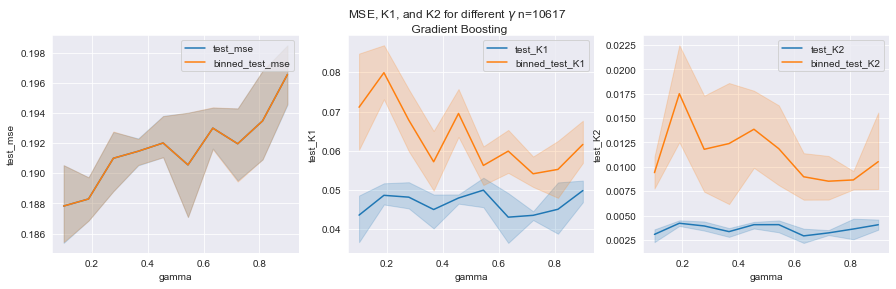

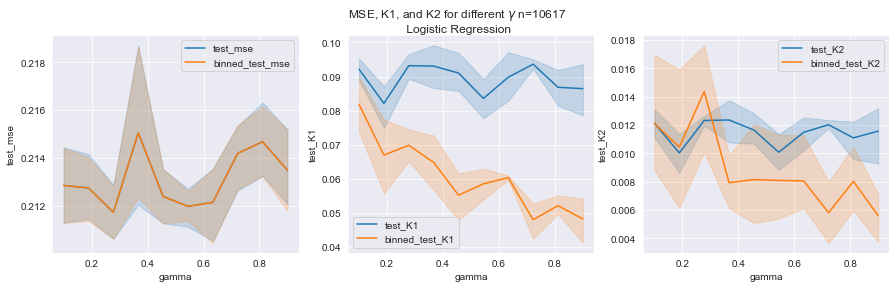

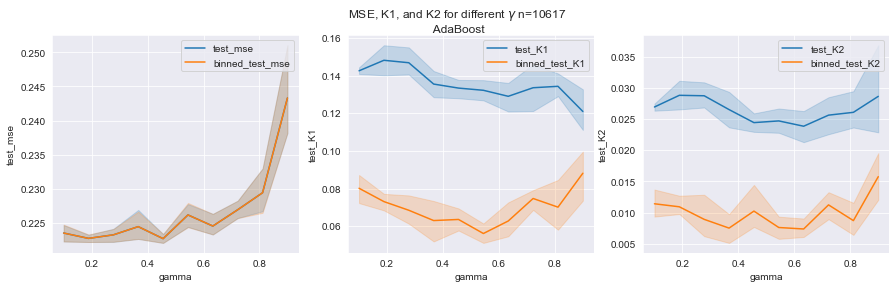

In [48]:
results_df = pd.DataFrame(results)
n_tot = len(X_train) + len(X_cal)
for clf, clf_name in clfs:
  fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
  sns.lineplot(data=results_df[results_df['clf']==clf_name], x='gamma', y='test_mse', label='test_mse', ax=ax1)
  sns.lineplot(data=results_df[results_df['clf']==clf_name], x='gamma', y='test_mse', label='binned_test_mse', ax=ax1)
  sns.lineplot(data=results_df[results_df['clf']==clf_name], x='gamma', y='test_K1', label='test_K1', ax=ax2)
  sns.lineplot(data=results_df[results_df['clf']==clf_name], x='gamma', y='binned_test_K1', label='binned_test_K1', ax=ax2)
  sns.lineplot(data=results_df[results_df['clf']==clf_name], x='gamma', y='test_K2', label='test_K2', ax=ax3)
  sns.lineplot(data=results_df[results_df['clf']==clf_name], x='gamma', y='binned_test_K2', label='binned_test_K2', ax=ax3)
  plt.suptitle(f"MSE, K1, and K2 for different $\gamma$ n={n_tot} \n {clf_name}")
  plt.show()

Text(0, 0.5, '$E[y]$')

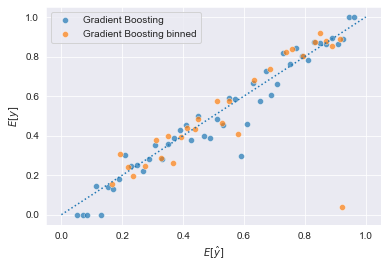

In [10]:
clf_name = "Gradient Boosting"
for name in [clf_name, f"{clf_name} binned"]:
  mean_proba, mean_true = reliab_plot[name]
  sns.scatterplot(x=mean_proba, y=mean_true, alpha=0.7, label=name)

plt.plot([0, 1], [0, 1], label="y=x", linestyle=":")
plt.xlabel(r"$E[\hat{y}]$")
plt.ylabel(r"$E[y]$")

## Manual Heuristic
Once the calibration set stops improving, we use the rest of the data for calibration

In [53]:
X_train, X_cal, y_train, y_cal = train_test_split(X, y, test_size=calibration_ratio)

In [54]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
results = []
clf = Pipeline([('scaler', StandardScaler()), ('svc', LogisticRegression())])
clf_name = 'logistic regression'


best_mse = 10000
for clf, clf_name in clfs: 
    for n in range(1000, len(X_train), 1000): 
        print(n)
        # sample n datapoints from x_train 
    
        sample_ind = np.random.choice(len(X_train), n, replace=False)
        clf = Pipeline([('scaler', StandardScaler()), (clf_name, clf)])
        clf.fit(X_train.values[sample_ind], y_train.values[sample_ind])
        y_pred = clf.predict_proba(X_cal)[:, 1]
        mean_proba, mean_true, K1, K2 = ut.expected_calibration_error(np.asarray(y_cal), y_pred, num_bins=B)
        mse = mean_squared_error(y_pred, y_cal)
        if mse < best_mse: 
            best_mse = mse
        
        auc = roc_auc_score(y_cal, y_pred)
        print(clf_name)
        print('AUC on test set:     {:6.3f}'.format(auc))
        print(f'K1 error {K1} K2 error {K2}')
    
        results.append({
          'test_AUC': auc,
          'test_mse': mse,
          'test_K1': K1,
          'test_K2': K2,
          'clf': clf_name,
          'B': B, 
          'n': n,
        
    })

1000
Gradient Boosting
AUC on test set:      0.754
K1 error 0.054139179031887315 K2 error 0.004540255614697497
2000
Gradient Boosting
AUC on test set:      0.775
K1 error 0.03522315198354528 K2 error 0.0020202006627771363
3000
Gradient Boosting
AUC on test set:      0.775
K1 error 0.04213486619549462 K2 error 0.003477721011491837
4000
Gradient Boosting
AUC on test set:      0.775
K1 error 0.05038777305668065 K2 error 0.00365983202394334
5000
Gradient Boosting
AUC on test set:      0.782
K1 error 0.03986511143220631 K2 error 0.00265968598642647
6000
Gradient Boosting
AUC on test set:      0.779
K1 error 0.044411105348931244 K2 error 0.003522650583081055
7000
Gradient Boosting
AUC on test set:      0.776
K1 error 0.04489821994027821 K2 error 0.003354576528660766
8000
Gradient Boosting
AUC on test set:      0.780
K1 error 0.04275903599115643 K2 error 0.003391698885150822
9000
Gradient Boosting
AUC on test set:      0.780
K1 error 0.042324896057493615 K2 error 0.0027229204627231924
10000
G

<AxesSubplot:xlabel='n', ylabel='test_mse'>

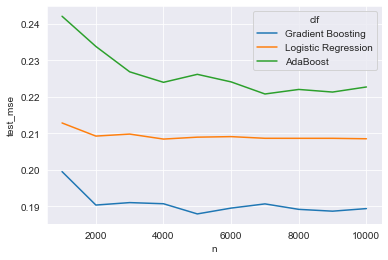

In [55]:
sns.lineplot(data=pd.DataFrame(results), x='n', y='test_mse', hue='clf')